딥러닝 파이토치 교과서
ch5. 3
 p.200~229

# CH5. 합성곱 신경망 1

## 5.3 전이 학습

전이 학습 (transfer learning)
- 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미
 - 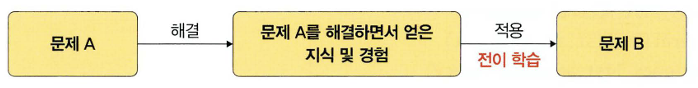
- 특성 추출과 미세 조정 기법이 있음

### 5.3.1 특성 추출 기법
특성 추출 (feature extractor)
- ImageNet 데이터셋으로 사전 훈련되 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦
- 학습할 때 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 함
 - 합성곱층 : 합성곱층과 풀링층으로 구성
 - 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
- 사전 훈련된 네트워크의 합성곱층에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킴
 -


사용 가능한 이미지 분류 모델
- Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet

특성 추출 기법
- 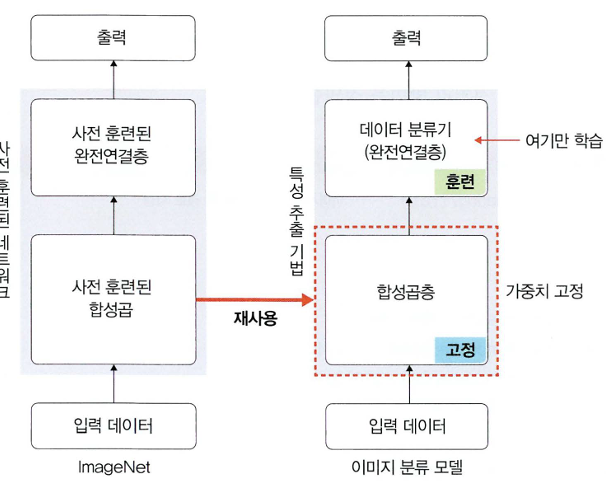

라이브러리 호출

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

이미지 데이터 전처리 방법 정의

In [ ]:
data_path = '/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/catanddog/train'

transform = transforms.Compose(
    [
     transforms.Resize([256,256]),
     transforms.RandomResizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()
]) # 1
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
) # 2
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size =32,
    num_workers = 8,
    shuffle = True
) # 3
print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1. torchvision.transform ; 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환해 줌
- Resize : 이미지 크기를 조정 (256 x 256 크기로 이미지 데이터를 조정)
- RandomResizedCrop : 이미지를 랜덤한 크기 및 비율로 자름, 데이터 확장 용도로 사용됨
- RandomHorizontalFilp : 이미지를 랜덤하게 수평으로 뒤집음
- ToTensor : 이미지 데이터를 텐서로 변환

2. datasets.ImageFolder : 데이터로더가 데이터를 불러올 대상과 방법을 정의
- data_path : 불러올 데이터가 위치한 경로
- transform=transform : 이미지 데이터에 대한 전처리

3. 데이터로더는 데이터를 불러오는 부분으로 ImageFolder을 데이터로더에 할당함. 한 번에 불러올 데이터양을 결정하는 batch_size를 지정. 데이터를 무작위로 섞을 것인지도 설정
- train_dataset : 데이터셋을 지정
- batch_size = 32 : 한 번에 불러올 데이터양을 결정하는 배치 크기를 설정
- num_workers = 8 : 데이터를 불러올 때 사용할 하위 프로세스의 개수
- shuffle : 데이터를 무작위로 섞을지 지정

-------
RandomResizedCrop : 데이터 확장하기



```
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon.data.vision import transforms

example_image = mx.image.imread('/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/cat.jpg')
plt.imshow(example_image.asnumpy()) # 불러온 이미지 출력
```

불러온 이미지에 RandomResizedCrop을 적용하기 위한 함수 생성


```
def show_images(imgs, num_rows, num_cols, scale=2):
    aspect_ratio = i

```

불러온 이미지에 RandomResizedCrop을 적용하기 위한 함수 생성

```
mgs[0].shape[0]/imgs[0].shape[1] # 확장할 이미지의 크기 조정
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols) :
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False) # x축 전체를 숨김
            axes[i][j].axes.get_yaxis().set_visible(False) # y축 전체를 숨김
    plt.subplots_adjust(hspace = 0.1, wspace=0)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)] # 다양한 샘플을 얻기 위해 여러 번 데이터 확장 적용
    show_images(Y, num_rows, num_cols, scale)
```
RandomResizedCrop이 적용된 이미지 출력하기



```
shape_aug = transforms.RandomResizedCrop(sixe = (200,200),
                                         scale = (0.1, 1),
                                         ratio = (0.5, 2))

apply(example_image, shape_aug)
```

- size : 출력할 크기를 200x200으로 조정
- scale : 면적 비율을 0.1 ~ 1 범위 내에서 무작위로 자르기
- ratio : 면적의 너비와 높이 비율을 0.5 ~ 2 범위 내에서 무작위로 조절
-----------

24개의 이미지에 대해 레이블 정보와 함께 출력하기

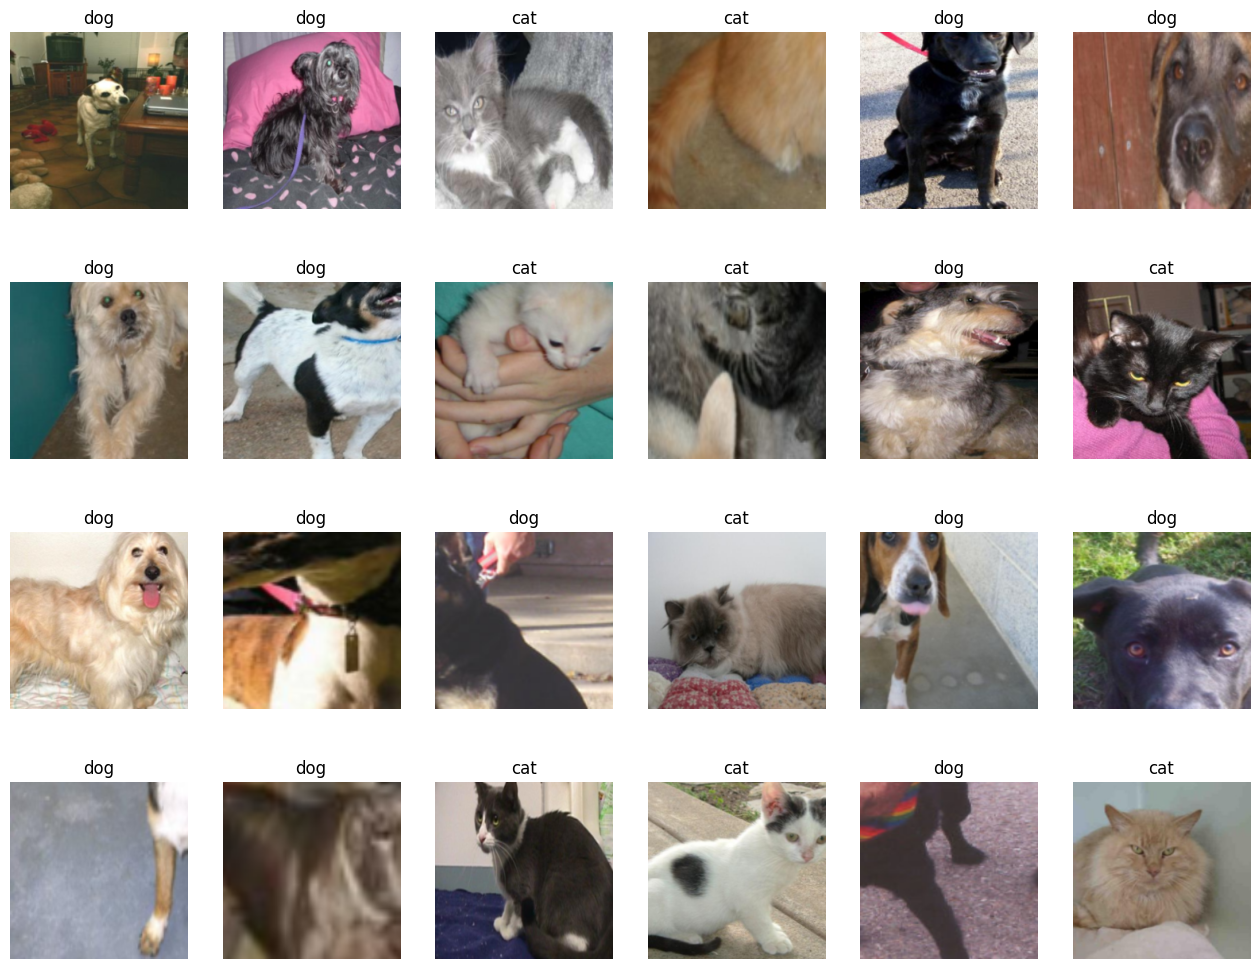

In [ ]:
import numpy as np

samples, labels = next(iter(train_loader)) # 1
classes = {0: 'cat', 1:'dog'} # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16,25))
for i in range(24) : # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # 2
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

1. 반복자(iterator, for 구문과 같은 효과) 사용 위해서 iter(), next() 필요
- iter() : 전달된 데이터의 반복자를 꺼내 반환
- next() : 그 반복자가 다음에 출력해야 할 요소를 반환

2. np.transpose : 행과 열을 바꿈으로써 행렬의 차원을 바꿈
- 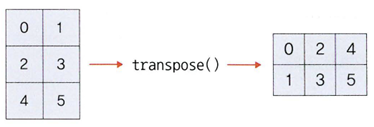
- 내적 연산이 가능하게끔 차원 조정하기

사전 훈련된 모델 내려받기

In [ ]:
resnet18 = models.resnet18(pretrained=True) # 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


- ResNet18
 - 50개의 계층으로 구성된 합성곱 신경망
 - ImageNet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망
 - 전이 학습에 사용되도록 사전 훈련된 모델을 제공함
 - 입력 제약이 매우 크고, 충분한 메모리가 없으면 학습 속도가 느릴 수 있다는 단점

사전 훈련된 모델의 파라미터 학습 유무 지정

In [ ]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting :
        for param in model.parameters():
            param.requires_grad = False # 1
set_parameter_requires_grad(resnet18)

1. requires_grad = False
- 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음
- 모델의 일부(합성곱층, 풀링츨)를 고정하고 나머지를 학습하고자 할 때

ResNet18에 완전연결층 추가
 - 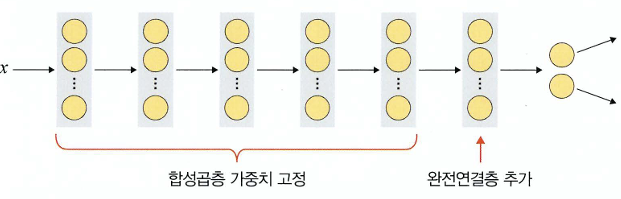

In [ ]:
resnet18.fc = nn.Linear(512,2) # 2 : 클래스가 두 개

모델의 파라미터 값 확인

In [ ]:
for name, param in resnet18.named_parameters() : # model.names_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0015, -0.0329, -0.0295,  ...,  0.0011, -0.0321, -0.0311],
        [-0.0117,  0.0196, -0.0201,  ...,  0.0215, -0.0277,  0.0226]])
fc.bias tensor([ 0.0343, -0.0044])


모델 객체 생성 및 손실 함수 정의

In [ ]:
model = models.resnet18(pretrained = True) # 모델의 객체 생성

for param in model.parameters() : # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters() : # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

모델 학습 위한 함수 생성

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs) : # 에포크만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in dataloaders : # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad() # 기울기를 0으로 설정
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print('Loss: {:.4f} Acc {:.4f}'.format(epoch_loss, epoch_acc) )

        if epoch_acc > best_acc :
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/catanddog/',
                                                    '{0:0=2d}.pth'.format(epoch))) # 모델 재사용 위해 저장
        print()

    time_elapsed = time.time() - since # 실행시간을 계산
    print('Training complete in {:.0f}m {:.0f}s'. format(time_elapsed // 60,
                                                         time_elapsed % 60))
    print('Best Acc:{:4f}'.format(best_acc))
    return acc_history, loss_history # 모델 정확도와 오차를 반환


ResNet18에 추가된 완전연결층은 학습을 하도록 설정

파라미터 학습 결과를 옵티마이저에 전달

In [ ]:
params_to_updata = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True :
        params_to_updata.append(param) # 파라미터 학습 결과를 저장
        print('\t', name)

optimizer = optim.Adam(params_to_updata) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


모델 학습

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실 함수 저장
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss: 0.6554 Acc 0.5870

Epoch 1/12
----------
Loss: 0.3866 Acc 0.8494

Epoch 2/12
----------
Loss: 0.3615 Acc 0.8494

Epoch 3/12
----------
Loss: 0.3118 Acc 0.8494

Epoch 4/12
----------
Loss: 0.2757 Acc 0.9065

Epoch 5/12
----------
Loss: 0.2392 Acc 0.8961

Epoch 6/12
----------
Loss: 0.2486 Acc 0.8909

Epoch 7/12
----------
Loss: 0.2874 Acc 0.8727

Epoch 8/12
----------
Loss: 0.1828 Acc 0.9403

Epoch 9/12
----------
Loss: 0.1982 Acc 0.9273

Epoch 10/12
----------
Loss: 0.1723 Acc 0.9325

Epoch 11/12
----------
Loss: 0.1925 Acc 0.9169

Epoch 12/12
----------
Loss: 0.2478 Acc 0.8779

Training complete in 0m 51s
Best Acc:0.940260


=> 약 94%로 높은 정확도

테스트 데이터 호출 및 전처리

In [ ]:
test_path = '/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = True
)

print(len(test_dataset))

테스트 데이터 평가 함수 생성

In [ ]:
def eval_model(model, dataloaders, device) :
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/catanddog/' + '*.pth') # 1
    saved_models.sort() # 불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)

    for model_path in saved_models :
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders : # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad() : # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs 에 저장

            _, preds = torch.max(outputs.data, 1) # 2
            preds[preds >= 0.5] = 1 # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0 # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            running_corrects += preds.eq(labels.cpu()).int().sum() # 3

        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc :
            best_acc = epoch_acc
            acc_history.append(epoch_acc.item())
            print()

        time_elapsed = time.time() - since
        print('Validation complete in {:.0f}m {;.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best Acc: {:.4f}'.format(best_acc))

        return acc_history # 계산된 정확도 반환

1. glob : 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용
2. torch.max : 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환하는 함수
3. preds.eq(labels) : preds 배열과 labels 가 일치하는지 검사하는 용도로 사용

테스트 데이터를 평가 함수에 적용

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

=> 테스트 데이터 역시 94% 정도의 높은 정확도를 보임

훈련과 테스트 데이터의 정확도를 그래프로 확인

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

훈련 데이터의 오차에 대한 그래프 확인

In [ ]:
plt.plot(train_loss_hist)
plt.show()

예측 이미지 출력을 위한 전처리 함수

In [ ]:
def im_convert(tensor) :
    image = tensor.clone().detach().numpy() # 1
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0,1) # 2
    return image

1.
- tensor.clone() : 기존 텐서의 내용을 복사한 텐서를 생성하겠다
- detach() : 기존 텐서에서 기울기가 전파되지 않는 텐서
- tesnsor.clone().detach() : 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지 않겠다는 의미
 - 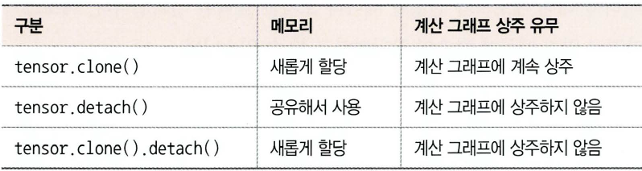


계산 그래프
- 계산 그래프 : 계산 과정을 그래프로 나타낸 것
- 여러 개의 노드와 그 노드들을 연결하는 선인 에지로 구성됨
 - 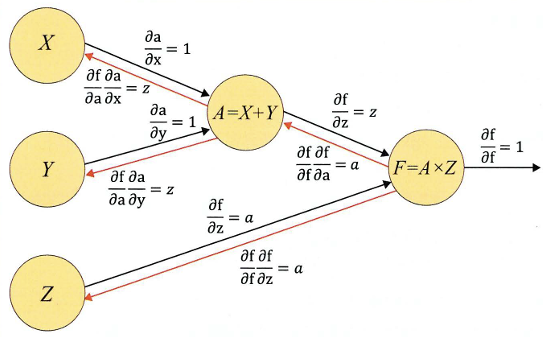
- 국소적 계산이 가능
- 역전파를 통한 미분 계산이 편리

연쇄 법칙
- 연쇄 법칙 (체인룰) : 두 개 이상의 함수가 결합된 함수, 합성 함수의 미분법

2. clip() : 입력값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용



```
image.clip(0,1) # image 데이터를 0과 1 사이의 값으로 제한
```



In [ ]:
import numpy as np
exam = np.array([-1.8 ,-1.2, -0.7, 0.0, 0.8, 1.4, 1.9])
print(exam)
print(np.clip(exam, -0.5, 0.5))

테스트 데이터셋을 이용하여 실제로 개와 고양이 잘 분류하는지 예측 결과 출력

In [ ]:
classes = {0: 'cat', 1: 'dog'} # 개와 고양이 두 개에 대한 레이블

dataiter = iter(test_loader) # 테스트 데이터셋을 가져오기
images, labels = dataiter.next() # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옴
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20) :
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = []) # 1
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=('green' if preds[idx]==labels[idx] else 'red')) # 2
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0 ) # 3

1. add_subplot : 한 화면에 여러 개의 이미지를 담기 위해 사용
2. classes[preds[idx].item()] : preds[idx].item() 값이 classes로 정의된 '0'과 '1' 중 어떤 값을 갖는지 판별하겠다는 의미
- 0이면 고양이, 1이면 개
3. Figure 안에서 서브 플롯의 위치를 조정할 때 사용함
- 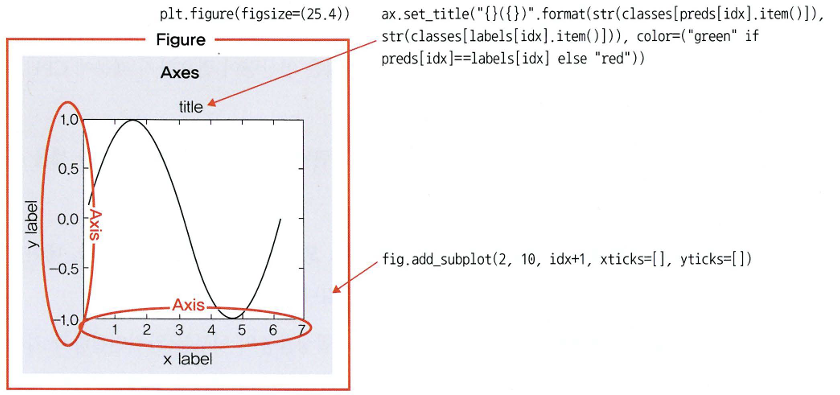

### 5.3.2 미세 조정 기법

미세 조정 기법

: 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식

- 특성 추출은 목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있음
- 특성이 잘못 추출되었다면 미세 조정 기법으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출할 수 있음
- 사전 훈련된 네트워크를 미세 조정하여 분석하려는 데이터셋에 잘 맞도록 모델의 파라미터를 조정하는 기법

미세 조정 기법의 전략 : 훈련시키려는 데이터셋의 크기와 사전 훈련된 모델에 따른 전략
- 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우
 - 모델 전체를 재학습, 데이터셋 크기가 크기 때문에 재학습시키는 것이 좋은 전략
- 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우
 - 합성곱층의 뒷부분과 데이터 분류기를 학습시키기
 - 데이터셋이 유사하기 때문에 전체를 학습시키는 것보다는 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류기만 새로 학습하더라도 최적의 성능을 낼 수 있음
- 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우
 - 합성곱층의 일부분과 데이터 분류기를 학습시킴
 - 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용한다고 해도 효과가 없을 수 있음
 - 합성곱층 중 어디까지 새로 학습시켜야 할지 적당히 설정해주어야 함
- 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우
 - 데이터 분류기만 학습시킴
 - 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 과적합이 발생
 - 최종 데이터 분류기인 완전연결층에 대해서만 미세 조정 기법을 적용

 - 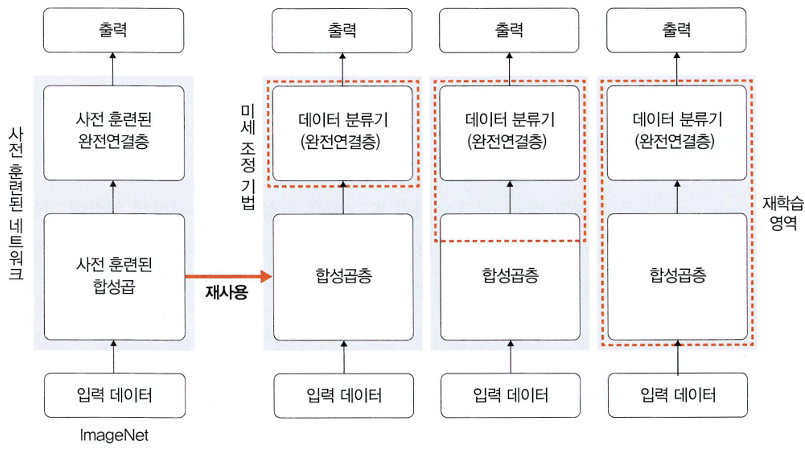

=> 파라미터 업데이트 과정에서 파라미터에 큰 변화를 주게 되면 과적합 문제가 발생할 수 있기 때문에 정교하고 미세한 파라미터 업데이트가 필요